In [1]:
!git clone https://github.com/michaelhasson/microtextures.git
%cd microtextures

Cloning into 'microtextures'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 127 (delta 11), reused 14 (delta 6), pack-reused 106
Receiving objects: 100% (127/127), 68.97 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (55/55), done.
/content/microtextures


In [2]:
import os
import torch
from torch.utils.data import DataLoader
from utils import *
import urllib
import gdown

In [3]:
# Set the paths to your image folder and where you want the CSV file of results to be exported
sample = 'MT101_3_15_24'
data_path = f"/content/microtextures/{sample}"

os.makedirs('/content/microtextures/predictions/', exist_ok=True)
csv_path = f"/content/microtextures/predictions/{sample}.csv"

# confidence_threshold = 0.25

In [4]:
url = 'https://drive.google.com/uc?export=download&id=1y6Ana6E-J4jjpc5r2K9fsyu7quA8bXZs'

model_path = 'qtz_final_model.pth'
gdown.download(url, model_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1y6Ana6E-J4jjpc5r2K9fsyu7quA8bXZs
From (redirected): https://drive.google.com/uc?export=download&id=1y6Ana6E-J4jjpc5r2K9fsyu7quA8bXZs&confirm=t&uuid=922a4f08-7122-4fc5-a1ed-6a7a72ef8e13
To: /content/microtextures/qtz_final_model.pth
100%|██████████| 283M/283M [00:04<00:00, 61.6MB/s]


'qtz_final_model.pth'

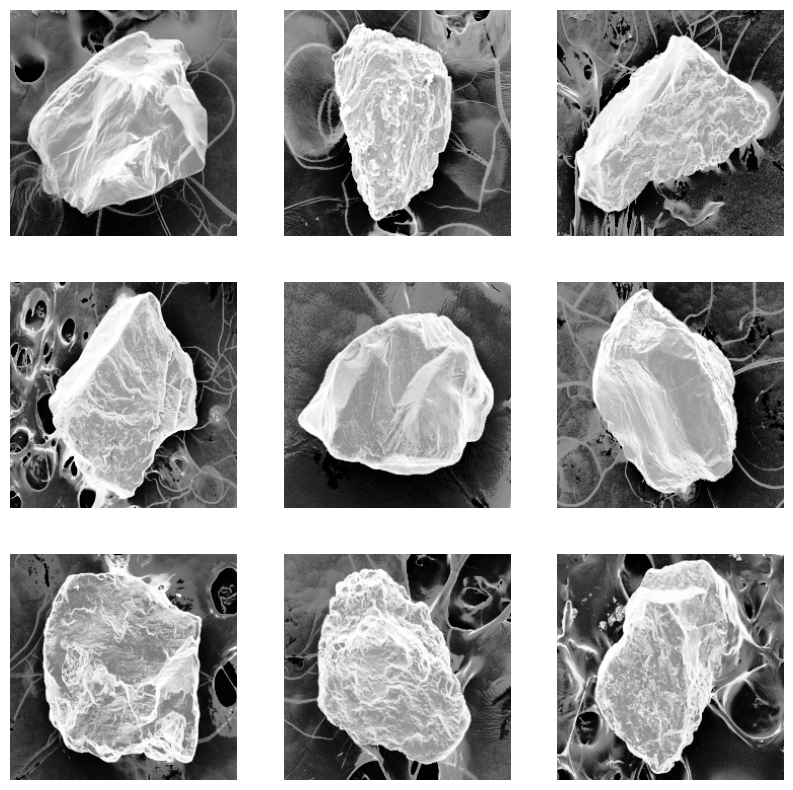

Predicting on sample MT101_3_15_24
Saved CSV at: /content/microtextures/predictions/MT101_3_15_24.csv


In [5]:
# Gather image paths
paths = []
for subdir, dirs, files in os.walk(data_path):
    for file in files:
        filepath = subdir + os.sep + file
        paths.append(filepath)

# Create the dataset and dataloader
imagedataset = CustomDataset(paths, transform=transform)
imagedl = DataLoader(imagedataset, batch_size=1, drop_last=False)

# Display random images
display_random_images(imagedataset)

# Make predictions! The default confidence threshold is 0.75. If you want to change the threshold, simply add it as an input argument after csv_path.
# It should look like: confidence_threshold=0.5. If you don't specify, the default will be used automatically.
make_predictions(sample, imagedataset, imagedl, model_path, csv_path)
